# Exercise: VPU and the DevCloud

Now that we've walked through the process of requesting a CPU with a VPU (Intel® NCS2) on Intel's DevCloud and loading a model on the Intel® NCS2, you will have the opportunity to do this yourself with the addition of running inference on an image using both a CPU and IGPU.

In this exercise, you will do the following:
1. Write a Python script to load a model and run inference 100 times on a device on Intel's DevCloud.
    * Calculate the time it takes to load the model.
    * Calculate the time it takes to run inference 100 times.
2. Write a shell script to submit a job to Intel's DevCloud.
3. Submit a job using `qsub` on an **IEI Tank-870** edge node, run `liveQStat` to view the status of your submitted jobs, then retrieve and view the results from your job.
    * One job using `CPU` as the device.
    * One job using `GPU` as the device.
    * One job using `VPU` as the device.
4. Plot and compare the results using bar graphs with `matplotlib` for the following metrics:
    * Model Loading Time
    * Inference Time
    * Frames Per Second (FPS)

Click the **Exercise Overview** button below for a demonstration.

<span class="graffiti-highlight graffiti-id_8egtpc8-id_0itthyg"><i></i><button>Exercise Overview</button></span>

#### IMPORTANT: Set up paths so we can run Dev Cloud utilities
You *must* run this every time you enter a Workspace session.

In [1]:
%env PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support
import os
import sys
sys.path.insert(0, os.path.abspath('/opt/intel_devcloud_support'))
sys.path.insert(0, os.path.abspath('/opt/intel'))

env: PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support


## The Model

We will be using the `vehicle-license-plate-detection-barrier-0106` model for this exercise.

Remember to use the appropriate model precisions for each device:

* CPU - `FP32`
* IGPU - `FP16`
* VPU - `FP16`

The model has already been downloaded for you in the `/data/models/intel` directory on Intel's DevCloud.

We will be running inference on an image of a car. The path to the image is `/data/resources/car.png`.

# Step 1: Creating a Python Script

The first step is to create a Python script that you can use to load the model and perform inference. We'll use the `%%writefile` magic to create a Python file called `inference_on_device.py`. In the next cell, you will need to complete the `TODO` items for this Python script.

`TODO` items:

1. Load the model

2. Get the name of the input node

3. Prepare the model for inference (create an input dictionary)

4. Run inference 100 times in a loop

If you get stuck, you can click on the **Show Solution** button below for a walkthrough with the solution code.

In [2]:
%%writefile inference_on_device.py

import time
import numpy as np
import cv2
from openvino.inference_engine import IENetwork
from openvino.inference_engine import IECore
import argparse

def main(args):
    model=args.model_path
    model_weights=model+'.bin'
    model_structure=model+'.xml'
    
    start=time.time()
    
    # TODO: Load the model
    model = IENetwork(model_structure, model_weights)
    
    core = IECore()
    net = core.load_network(network = model, device_name = args.device, num_requests = 1)
    
    load_time=time.time()-start
    print(f"Time taken to load model = {load_time} seconds")
    
    # Get the name of the input node
    input_name = next(iter(model.inputs))
    
    # Reading and Preprocessing Image
    input_img=cv2.imread('/data/resources/car.png')
    input_img=cv2.resize(input_img, (300,300), interpolation = cv2.INTER_AREA)
    input_img=np.moveaxis(input_img, -1, 0)

    # TODO: Prepare the model for inference (create input dict etc.)
    input_dict = {input_name:input_img}
    
    start=time.time()
    for _ in range(100):
        # TODO: Run Inference in a Loop
        net.infer(input_dict)
    
    inference_time=time.time()-start
    fps=100/inference_time
    print(f"Time Taken to run 100 inference is = {inference_time} seconds")
    
    with open(f"/output/{args.path}.txt", "w") as f:
        f.write(str(load_time)+'\n')
        f.write(str(inference_time)+'\n')
        f.write(str(fps)+'\n')

if __name__=='__main__':
    parser=argparse.ArgumentParser()
    parser.add_argument('--model_path', required=True)
    parser.add_argument('--device', default=None)
    parser.add_argument('--path', default=None)
    
    args=parser.parse_args() 
    main(args)

Overwriting inference_on_device.py


<span class="graffiti-highlight graffiti-id_l7v4f6u-id_oeichcd"><i></i><button>Show Solution</button></span>

## Step 2: Creating a Job Submission Script

To submit a job to the DevCloud, you'll need to create a shell script. Similar to the Python script above, we'll use the `%%writefile` magic command to create a shell script called `inference_model_job.sh`. In the next cell, you will need to complete the `TODO` items for this shell script.

`TODO` items:
1. Create three variables:
    * `DEVICE` - Assign the value as the first argument passed into the shell script.
    * `MODELPATH` - Assign the value as the second argument passed into the shell script.
    * `SAVEPATH` - Assign the value as the third argument passed into the shell script.
2. Call the Python script using the three variable values as the command line argument

If you get stuck, you can click on the **Show Solution** button below for a walkthrough with the solution code.

In [3]:
%%writefile inference_model_job.sh
#!/bin/bash

exec 1>/output/stdout.log 2>/output/stderr.log

mkdir -p /output

# TODO: Create DEVICE variable
DEVICE=$1
# TODO: Create MODELPATH variable
MODELPATH=$2
# TODO: Create SAVEPATH variable
SAVEPATH=$3

# TODO: Call the Python script
python3 inference_on_device.py --model_path ${MODELPATH} --device ${DEVICE} --path ${SAVEPATH}

cd /output

tar zcvf output.tgz * # compresses all files in the current directory (output)

Overwriting inference_model_job.sh


<span class="graffiti-highlight graffiti-id_muqucn2-id_g84tg5a"><i></i><button>Show Solution</button></span>

## Step 3: Submitting a Job to Intel's DevCloud

In the next three sub-steps, you will write your `!qsub` commands to submit your jobs to Intel's DevCloud to load your model and run inference on the **IEI Tank-870** edge node with an **Intel Core i5** CPU and an **Intel Neural Compute Stick 2** VPU.

Your `!qsub` command should take the following flags and arguments:
1. The first argument should be the shell script filename
2. `-d` flag - This argument should be `.`
3. `-l` flag - This argument should request an edge node with an **IEI Tank-870**. The default quantity is 1, so the **1** after `nodes` is optional. 
    * **Intel Core i5 6500TE** for your `CPU`.
    * **Intel HD Graphics 530** for your `GPU`.
    * **Intel Neural Compute Stick 2** for your `VPU`.

To get the queue labels for these devices, you can go to [this link](https://devcloud.intel.com/edge/get_started/devcloud/)

4. `-F` flag - This argument should contain the three values to assign to the variables of the shell script:
    * **DEVICE** - Device type for the job: `CPU`,`GPU` or `MYRIAD`.
    * **MODELPATH** - Full path to the model for the job. As a reminder, the model is located in `/data/models/intel`.
    * **SAVEPATH** - Name of the file you want to save the performance metrics as. These should be named as the following:
        - `cpu_stats` for the `CPU` job
        - `vpu_stats` for the `VPU` job
        - `gpu_stats` for the `GPU` job

**Note**: There is an optional flag, `-N`, you may see in a few exercises. This is an argument that only works on Intel's DevCloud that allows you to name your job submission. This argument doesn't work in Udacity's workspace integration with Intel's DevCloud.

## Step 3a: Running on the NCS2

In the cell below, write the qsub command that will submit your job to the VPU (NCS2).

If you get stuck, you can click on the **Show Solution** button below for a walkthrough with the solution code.

In [4]:
vpu_job_id_core = !qsub inference_model_job.sh -d . -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "MYRIAD /data/models/intel/vehicle-license-plate-detection-barrier-0106/FP16/vehicle-license-plate-detection-barrier-0106 vpu_stats" -N store_core # TODO: Write qsub command
print(vpu_job_id_core[0])

kv94Bk6J5UXkEI4rqJTsduj6eWUjglTE


<span class="graffiti-highlight graffiti-id_g3v8ffh-id_bvjbx8j"><i></i><button>Show Solution</button></span>

### Check Job Status

To check on the job that was submitted, use `liveQStat` to check the status of the job. The cell is locked until this finishes polling 10 times or you can interrupt the kernel to stop it by pressing the stop button at the top: ![stop button](assets/interrupt_kernel.png)

Column `S` shows the state of your running jobs.

For example:
- If `JOB ID`is in Q state, it is in the queue waiting for available resources.
- If `JOB ID` is in R state, it is running.

In [5]:
import liveQStat
liveQStat.liveQStat()

###### Get Results

Run the next cell to retrieve your job's results.

In [6]:
import get_results

get_results.getResults(vpu_job_id_core[0], filename="output.tgz", blocking=True)

getResults() is blocking until results of the job (id:kv94Bk6J5UXkEI4rqJTsduj6eWUjglTE) are ready.
Please wait...Success!
output.tgz was downloaded in the same folder as this notebook.


###### Unpack your output files and view stdout.log

In [7]:
!tar zxf output.tgz

In [8]:
!cat stdout.log

Time taken to load model = 2.4910874366760254 seconds
Time Taken to run 100 inference is = 3.18913197517395 seconds
stderr.log


###### View stderr.log
This can be used for debugging

In [9]:
!cat stderr.log

inference_on_device.py:17: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  model = IENetwork(model_structure, model_weights)


## Step 3b: Running on the CPU

In the cell below, write the qsub command that will submit your job to the CPU.

If you get stuck, you can click on the **Show Solution** button below for a walkthrough with the solution code.

In [10]:
cpu_job_id_core = !qsub inference_model_job.sh -d . -l nodes=1:tank-870:i5-6500te -F "CPU /data/models/intel/vehicle-license-plate-detection-barrier-0106/FP32/vehicle-license-plate-detection-barrier-0106 cpu_stats" -N store_core # TODO: Write qsub command
print(cpu_job_id_core[0])

vdimChGQqcrx48uWa9AbzjK3DVXxd4Bg


<span class="graffiti-highlight graffiti-id_e6ujds3-id_ar4zvdk"><i></i><button>Show Solution</button></span>

### Check Job Status

To check on the job that was submitted, use `liveQStat` to check the status of the job. The cell is locked until this finishes polling 10 times or you can interrupt the kernel to stop it by pressing the stop button at the top: ![stop button](assets/interrupt_kernel.png)

Column `S` shows the state of your running jobs.

For example:
- If `JOB ID`is in Q state, it is in the queue waiting for available resources.
- If `JOB ID` is in R state, it is running.

In [11]:
import liveQStat
liveQStat.liveQStat()

###### Get Results

Run the next cell to retrieve your job's results.

In [12]:
import get_results

get_results.getResults(cpu_job_id_core[0], filename="output.tgz", blocking=True)

getResults() is blocking until results of the job (id:vdimChGQqcrx48uWa9AbzjK3DVXxd4Bg) are ready.
Please wait...Success!
output.tgz was downloaded in the same folder as this notebook.


###### Unpack your output files and view stdout.log

In [13]:
!tar zxf output.tgz

In [14]:
!cat stdout.log

Time taken to load model = 1.1151814460754395 seconds
Time Taken to run 100 inference is = 0.34905529022216797 seconds
cpu_stats.txt
stderr.log


###### View stderr.log
This can be used for debugging

In [15]:
!cat stderr.log

inference_on_device.py:17: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  model = IENetwork(model_structure, model_weights)


## Step 3c: Running on the GPU

In the cell below, write the qsub command that will submit your job to the GPU.

If you get stuck, you can click on the **Show Solution** button below for a walkthrough with the solution code.

In [16]:
gpu_job_id_core = !qsub inference_model_job.sh -d . -l nodes=1:tank-870:i5-6500te:intel-hd-530 -F "GPU /data/models/intel/vehicle-license-plate-detection-barrier-0106/FP16/vehicle-license-plate-detection-barrier-0106 gpu_stats" -N store_core # TODO: Write qsub command
print(gpu_job_id_core[0])

YFJN9olq9597dlzaCGTeRbPcwN6o0zit


<span class="graffiti-highlight graffiti-id_i3ywb2p-id_wq5meiq"><i></i><button>Show Solution</button></span>

### Check Job Status

To check on the job that was submitted, use `liveQStat` to check the status of the job. The cell is locked until this finishes polling 10 times or you can interrupt the kernel to stop it by pressing the stop button at the top: ![stop button](assets/interrupt_kernel.png)

Column `S` shows the state of your running jobs.

For example:
- If `JOB ID`is in Q state, it is in the queue waiting for available resources.
- If `JOB ID` is in R state, it is running.

In [17]:
import liveQStat
liveQStat.liveQStat()

###### Get Results

Run the next cell to retrieve your job's results.

In [18]:
import get_results

get_results.getResults(gpu_job_id_core[0], filename="output.tgz", blocking=True)

getResults() is blocking until results of the job (id:YFJN9olq9597dlzaCGTeRbPcwN6o0zit) are ready.
Please wait.........................Success!
output.tgz was downloaded in the same folder as this notebook.


###### Unpack your output files and view stdout.log

In [19]:
!tar zxf output.tgz

In [20]:
!cat stdout.log

Time taken to load model = 41.064186811447144 seconds
Time Taken to run 100 inference is = 0.5740683078765869 seconds
gpu_stats.txt
stderr.log


###### View stderr.log
This can be used for debugging

In [21]:
!cat stderr.log

inference_on_device.py:17: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  model = IENetwork(model_structure, model_weights)


## Step 4: Plot and Compare Results

Run the cell below to plot and compare the results.

In [22]:
import matplotlib.pyplot as plt

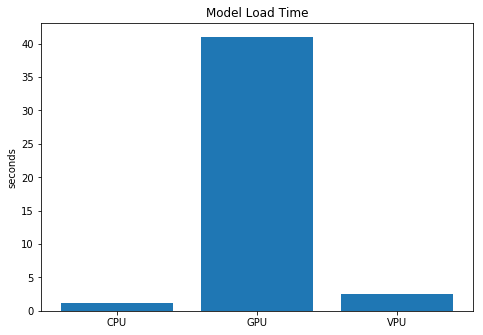

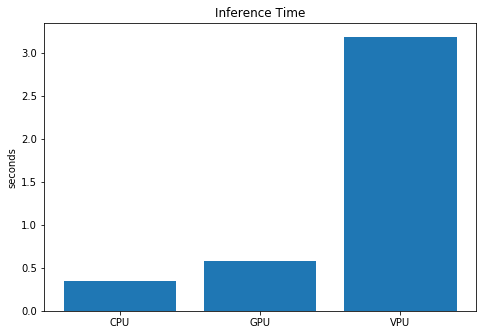

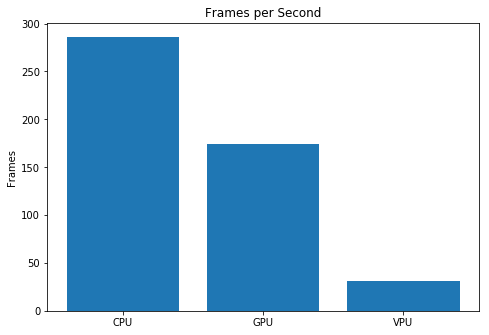

In [23]:
def plot(labels, data, title, label):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylabel(label)
    ax.set_title(title)
    ax.bar(labels, data)
    
def read_files(paths, labels):
    load_time=[]
    inference_time=[]
    fps=[]
    
    for path in paths:
        if os.path.isfile(path):
            f=open(path, 'r')
            load_time.append(float(f.readline()))
            inference_time.append(float(f.readline()))
            fps.append(float(f.readline()))

    plot(labels, load_time, 'Model Load Time', 'seconds')
    plot(labels, inference_time, 'Inference Time', 'seconds')
    plot(labels, fps, 'Frames per Second', 'Frames')

paths=['vpu_stats.txt', 'gpu_stats.txt', 'cpu_stats.txt']
read_files(paths, ['VPU', 'GPU', 'CPU'])